In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use("ggplot")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

Load data

In [3]:
data_dir = "../data"

transform = transforms.ToTensor()

test_dataset = datasets.FashionMNIST(
    root=data_dir,
    train=False,
    download=True,
    transform=transform
)

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

n_eval = 1000
eval_subset = Subset(test_dataset, range(n_eval))
eval_loader = DataLoader(eval_subset, batch_size=128, shuffle=False)


flat NumPy version for PCA

In [4]:
# build X_eval_flat (n_eval, 784)
images = []
labels = []

for i in range(n_eval):
    img, label = test_dataset[i]
    img = img.squeeze(0)
    images.append(img.numpy().reshape(-1))
    labels.append(label)

X_eval = np.stack(images, axis=0)  # (n_eval, 784)
y_eval = np.array(labels)

print("X_eval shape:", X_eval.shape)


X_eval shape: (1000, 784)


Reload the trained Autoencoder

In [5]:
LATENT_DIM = 64

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        x_hat = x_hat.view(-1, 1, 28, 28)
        return x_hat

model = Autoencoder(latent_dim=LATENT_DIM).to(device)

state_path = "../models/autoencoder_fmnist_latent64.pth"
model.load_state_dict(torch.load(state_path, map_location=device))
model.eval()


Autoencoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=64, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

AE reconstructions & MSE

In [6]:
all_orig_ae = []
all_rec_ae = []

with torch.no_grad():
    for imgs, _ in eval_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        
        all_orig_ae.append(imgs.cpu().numpy())
        all_rec_ae.append(outputs.cpu().numpy())

X_orig_ae = np.concatenate(all_orig_ae, axis=0)  # (n_eval, 1, 28, 28)
X_rec_ae = np.concatenate(all_rec_ae, axis=0)    # (n_eval, 1, 28, 28)

X_orig_ae_flat = X_orig_ae.reshape(n_eval, -1)
X_rec_ae_flat = X_rec_ae.reshape(n_eval, -1)

ae_mse = mean_squared_error(X_orig_ae_flat, X_rec_ae_flat)
print("Autoencoder (latent_dim=64) MSE:", ae_mse)


Autoencoder (latent_dim=64) MSE: 0.00970790721476078


PCA reconstruction with k = 64 on same eval set

In [7]:
k_pca = 64

pca_64 = PCA(n_components=k_pca)
X_eval_pca_transformed = pca_64.fit_transform(X_eval)
X_rec_pca_64 = pca_64.inverse_transform(X_eval_pca_transformed)

pca_64_mse = mean_squared_error(X_eval, X_rec_pca_64)
print("PCA (k=64) MSE:", pca_64_mse)


PCA (k=64) MSE: 0.009102225303649902


Visual side-by-side comparison

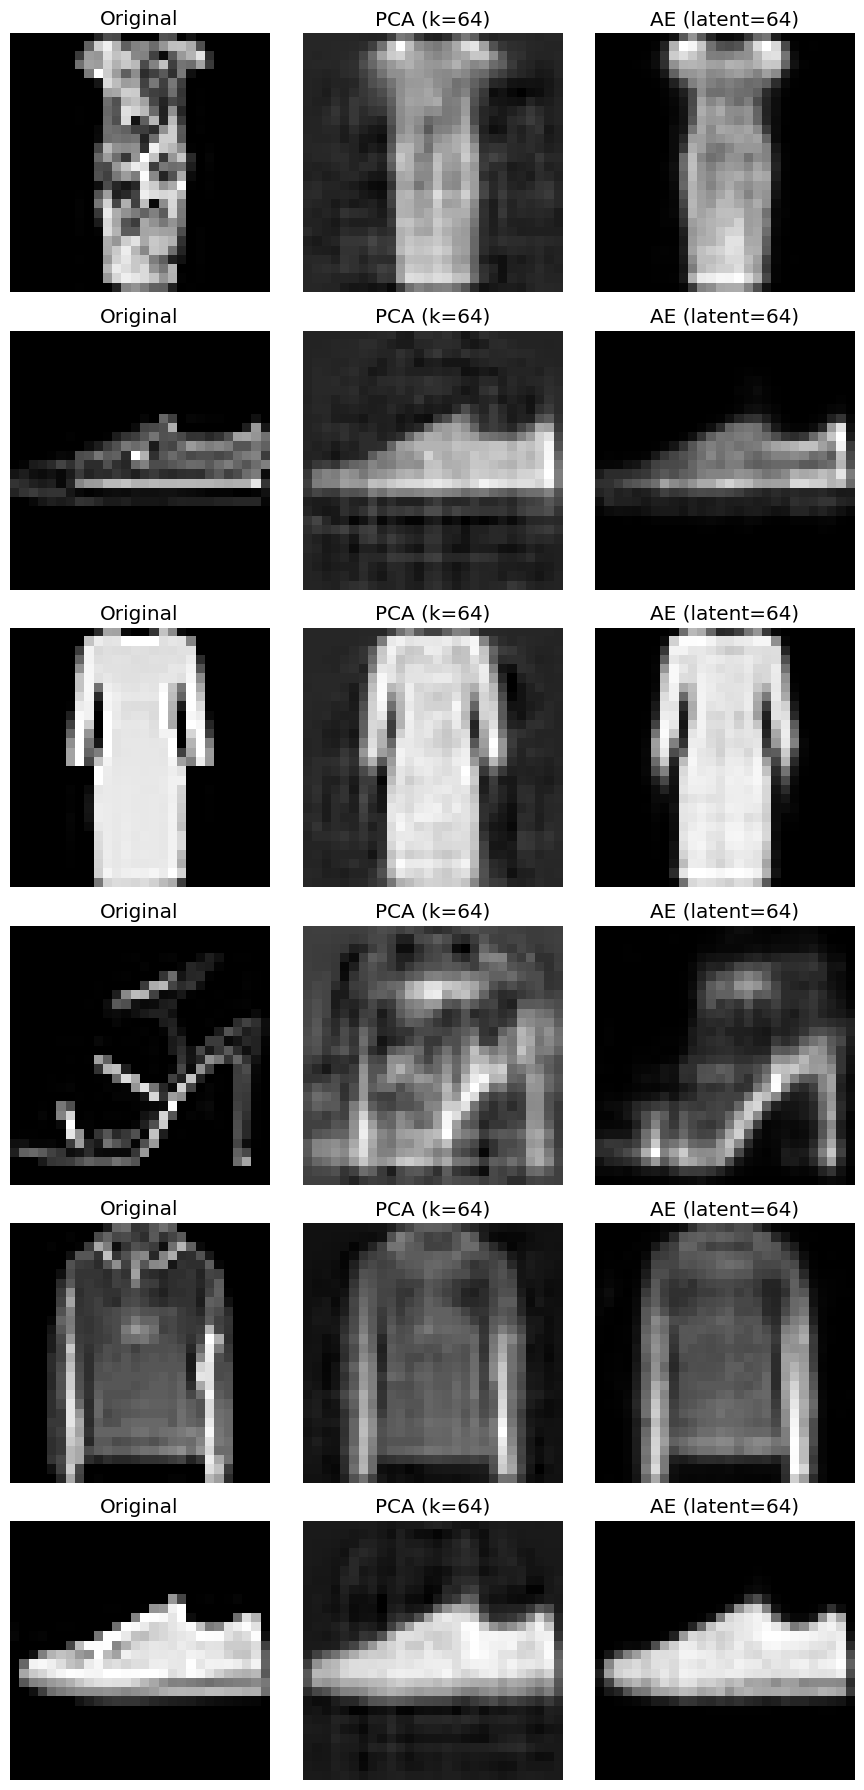

In [8]:
def show_pca_vs_ae(X_original_flat, X_rec_pca_flat, X_rec_ae_flat, n_images=5):
    idxs = np.random.choice(X_original_flat.shape[0], size=n_images, replace=False)
    
    fig, axes = plt.subplots(n_images, 3, figsize=(3 * 3, n_images * 3))
    
    for row, idx in enumerate(idxs):
        # original
        axes[row, 0].imshow(X_original_flat[idx].reshape(28, 28), cmap="gray")
        axes[row, 0].set_title("Original")
        axes[row, 0].axis("off")
        
        # PCA
        axes[row, 1].imshow(X_rec_pca_flat[idx].reshape(28, 28), cmap="gray")
        axes[row, 1].set_title("PCA (k=64)")
        axes[row, 1].axis("off")
        
        # AE
        axes[row, 2].imshow(X_rec_ae_flat[idx].reshape(28, 28), cmap="gray")
        axes[row, 2].set_title("AE (latent=64)")
        axes[row, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

show_pca_vs_ae(X_eval, X_rec_pca_64, X_rec_ae_flat, n_images=6)


In [9]:
print("PCA (k=64) MSE:       ", pca_64_mse)
print("Autoencoder (64-dim):", ae_mse)


PCA (k=64) MSE:        0.009102225303649902
Autoencoder (64-dim): 0.00970790721476078


## PCA vs Autoencoder: Quantitative & Visual Comparison

For **64-dimensional** compressed representations:

- **PCA (k = 64)**  
  - Reconstruction MSE ≈ 0.00910

- **Autoencoder (latent_dim = 64)**  
  - Reconstruction MSE ≈ 0.00971

Visually:

- Both methods reconstruct Fashion-MNIST images reasonably well.
- PCA reconstructions are slightly sharper in some global regions, consistent with its strong performance on overall variance.
- The autoencoder reconstructions are competitive, but with this architecture and training budget, they do not clearly outperform PCA.

**Key insight:**

- PCA already captures most of the essential variation in this dataset, and as the optimal linear method (for MSE), it is hard to beat.
- A nonlinear autoencoder has the potential to learn more complex manifolds, but this benefit may require:
  - convolutional architectures,
  - longer training,
  - or explicit denoising / task-specific objectives.

This comparison highlights that:
- Simple linear methods like PCA remain very strong baselines.
- Neural networks should be introduced when they provide clear **added value**, not just because they are more complex.
